<a href="https://colab.research.google.com/github/elvira123-hub/Extending_1D_to_3D_Schrodinger_Equation/blob/main/colab_SOFT_WALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#HERE CHANGE d only to control the confinement
#To get the value for Morse only, change the definition od the potential in both cases
#x, y, z are the position of Helium in Space

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt


# Constants
#d = 1.50  # for Infinity for De = 22.987
#d = 1.715 # TO TRY
d = 1.5 #THIS IS THE DISTANCE FROM THE BENZENE TO THE Helium atom
az = 1.4
bz = 7.0  #For this 3.0 -- -3.0 --> 0.4409
Nz = N = 51 #you can go up 65 or 85 and maybe a bit more but will be costy
h_bar = 1.9e5  # in KJ.A.mol-1.c-2
De_cuphe = 22.987 # in Kj/mol   # Dissociation energy
alpha_cuphe = 2.760  # in 1/(Angstrom)  # Variable related to the curvature of the curve
ze_cuphe = 1.693   # in (Angstrom)       # Minimum distance
De_benzhe = 1.51  # in Kj/mol   # Dissociation energy
alpha_benzhe = 1.61  # in 1/(Angstrom)  # Variable related to the curvature of the curve
ze_benzhe = 3.04  # in (Angstrom)       # Minimum distance
m_3He = 2.59e11  # in kj.mol-1.c^-2 For 3He
m_4He = 3.39e11  # in kj.mol-1.c^-2 For 4He

# Define the potential functions
def Anharm_potential(z_Morse, De, alpha):
    #return De * (1 - np.exp(-alpha * z_Morse)) ** 2 +De_cuphe
    return De * (1 - np.exp(-alpha * z_Morse)) ** 2

def compute_potential(distance, N, De, alpha, ze):
    distance_conf = abs(distance) - ze
    V1 = Anharm_potential(distance_conf, De, alpha)
    V_conf = 2 * V1
    V_conf_reshape = sparse.diags(V_conf.reshape((N + 1) ** 3), (0))
    return V_conf, V_conf_reshape

# Define the cases
cases = [
    {'aax': -0.5, 'bbx':0.5, 'aay': -0.5, 'bby': 0.5}
]
# Loop over the cases
for case in cases:
    aax = case['aax']
    aay = case['aay']
    bbx = case['bbx']
    bby = case['bby']

    # Generate grid
    aax = -0.5
    bbx = 0.5
    aay = -0.5
    bby = 0.5
    x = np.linspace(aax, bbx, N + 1, dtype=float)
    y = np.linspace(aay, bby, N + 1, dtype=float)
    z = np.linspace(az, bz, Nz + 1, dtype=float)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]

    X, Y, Z = np.meshgrid(x, y, z)

    # Construct the sparse matrices
    diag_1 = np.ones([N + 1])
    diag_2 = np.array([diag_1, -2 * diag_1, diag_1])
    B = sparse.spdiags(diag_2, np.array([-1, 0, 1]), N + 1, N + 1)
    BB = (1 / (dx ** 2)) * B
    CC = (1 / (dy ** 2)) * B
    DD = (1 / (dz ** 2)) * B
    C = sparse.kronsum(BB, CC)
    D = sparse.kronsum(C, DD)

    # Loop over the two masses
    for m in [m_3He, m_4He]:
        # Kinetic energy
        T = (-(h_bar ** 2) / (2 * m)) * D

        # Potential energy (Cu+-He)
        #distance = np.sqrt(X ** 2 + Y **2 + Z**2)
        distance = np.sqrt(Z**2)
        z_Morse = (distance - ze_cuphe)
        V_cuphe = Anharm_potential(z_Morse, De_cuphe, alpha_cuphe)
        V_cuphe_sparse = sparse.diags(V_cuphe.reshape((N + 1) ** 3), (0))

        # Potential energy (Benzene-He)
        #a_harm = 36.511   # curvature (kJ/mol·Å^−2)
        #c_harm = 1.5717   # energy offset (kJ/mol)
        #V_benzhe = a_harm * ((X-d)**2 + (Y-d)**2)                   # broadcasts over z
        #V_benzhe_reshape = sparse.diags(V_benzhe.reshape((N + 1) ** 3), 0)
        #V_benzhe, V_benzhe_reshape = compute_potential(distance, N, De_benzhe, alpha_benzhe, ze_benzhe)

        # ---- Four benzene rings around He (no function; direct expressions) ----
        # centers at (-d,0,0), (+d,0,0), (0,-d,0), (0,+d,0)

        # distances from He grid point (X,Y,Z) to each ring center
        r_left  = np.sqrt((X )**2 + Y**2       + Z**2)
        r_right = np.sqrt((X )**2 + Y**2       + Z**2)
        r_back  = np.sqrt( X**2       + (Y )**2 + Z**2)
        r_front = np.sqrt( X**2       + (Y )**2 + Z**2)

        # Morse displacements
        s_left  = r_left  - ze_benzhe
        s_right = r_right - ze_benzhe
        s_back  = r_back  - ze_benzhe
        s_front = r_front - ze_benzhe

        # Morse contributions (unshifted; minimum = 0 at r = ze)
        V_left  = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_left- d)))**2
        V_right = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_right +d)))**2
        V_back  = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_back -d)))**2
        V_front = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_front +d)))**2


        # total potential from four rings and its sparse diagonal form
        V_sum = V_left + V_right + V_back + V_front
        V_sum_sparse = sparse.diags(V_sum.reshape((N + 1)**3), 0, format='csr')


        # Total potential energy
        #V_total = sparse.diags((V_cuphe).reshape((N + 1) ** 3), (0))
        V_total = sparse.diags((V_cuphe + V_sum).reshape((N + 1) ** 3), (0))

        # Hamiltonian
        H = T + V_total

        # Eigenvalue and eigenvector computation
        eigenvalues, eigenvectors = eigsh(H, 1, which='SM', tol=1.e-15, ncv=100)

        # Ground state wavefunction
        def result(n):
            return eigenvectors.T[n].reshape((N + 1, N + 1, N + 1))

        def resultt(n):
            return eigenvectors[:,  n].reshape((N + 1, N + 1, N + 1))

        probability = (result(0) * resultt(0))


# === NEW CELL: print E0 for He-3 and He-4 vs box size (a = 1.0 → 3.0) ===
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh

def ground_energy(aax, aay, bbx, bby, mass, k=11):
    # grid (uses az, bz, Nz, N from your existing cell)
    #x = np.linspace(aax, bbx, N + 1, dtype=float)
    #y = np.linspace(aay, bby, N + 1, dtype=float)
    #z = np.linspace(az, bz, Nz + 1, dtype=float)
    #dx, dy, dz = x[1]-x[0], y[1]-y[0], z[1]-z[0]
    #X, Y, Z = np.meshgrid(x, y, z)

    # Laplacian (same stencil as your script)
    diag_1 = np.ones(N + 1)
    diag_2 = np.array([diag_1, -2*diag_1, diag_1])
    B  = sparse.spdiags(diag_2, np.array([-1, 0, 1]), N + 1, N + 1)
    BB = (1/(dx**2)) * B
    CC = (1/(dy**2)) * B
    DD = (1/(dz**2)) * B
    C  = sparse.kronsum(BB, CC)
    D  = sparse.kronsum(C, DD)

    # Kinetic + potentials (reuse your functions/constants)
    T = (-(h_bar**2)/(2*mass)) * D
    distance = np.sqrt(Z**2)
    #distance = np.sqrt(X**2 + Y**2 + Z**2)
    z_Morse  = distance - ze_cuphe
    V_cuphe  = Anharm_potential(z_Morse, De_cuphe, alpha_cuphe)
    #V_benzhe, V_benzhe_reshape = compute_potential(distance, N, De_benzhe, alpha_benzhe, ze_benzhe)
    #a_harm = 36.511   # curvature (kJ/mol·Å^−2)
    #c_harm = 1.5717   # energy offset (kJ/mol)
    #V_benzhe = a_harm * (X**2 + Y**2) + c_harm                     # broadcasts over z
    #V_benzhe_reshape = sparse.diags(V_benzhe.reshape((N + 1) ** 3), 0)


    ########################################################################################################
    r_left  = np.sqrt((X )**2 + Y**2       + Z**2)
    r_right = np.sqrt((X )**2 + Y**2       + Z**2)
    r_back  = np.sqrt( X**2       + (Y )**2 + Z**2)
    r_front = np.sqrt( X**2       + (Y )**2 + Z**2)

    # Morse displacements
    s_left  = np.abs(r_left  - ze_benzhe)
    s_right = np.abs(r_right - ze_benzhe)
    s_back  = np.abs(r_back  - ze_benzhe)
    s_front = np.abs(r_front - ze_benzhe)

    # Morse contributions (unshifted; minimum = 0 at r = ze)
    V_left  = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_left- d)))**2
    V_right = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_right +d)))**2
    V_back  = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_back -d)))**2
    V_front = De_benzhe * (1.0 - np.exp(-alpha_benzhe * (s_front +d)))**2



    # total potential from four rings and its sparse diagonal form
    V_sum = V_left + V_right + V_back + V_front
    V_sum_sparse = sparse.diags(V_sum.reshape((N + 1)**3), 0, format='csr')

    # Total potential energy
    V_total = sparse.diags((V_cuphe + V_sum).reshape((N + 1) ** 3), (0))
    #V_total  = sparse.diags((V_cuphe).reshape((N + 1)**3), 0)



    H = T + V_total
     # Smallest-magnitude k eigenvalues (ground + excited states)
    # Use a slightly larger ncv for stability with multiple eigenpairs
    k = int(k)
    ncv = max(2*k + 1, 105)
    vals, _ = eigsh(H, k=k, which='SM', tol=1e-12, ncv=ncv)
    vals = np.sort(np.real(vals-De_cuphe))
    return vals


# Use the same box from your 'cases' entry
_aax, _aay, _bbx, _bby = cases[0]['aax'], cases[0]['aay'], cases[0]['bbx'], cases[0]['bby']

# Compute and print for both masses
for label, mass in [("3He", m_3He), ("4He", m_4He)]:
    #eigvals = ground_energy(_ax, _ay, _bx, _by, mass, k=90)
    eigvals = ground_energy( aax, aay, bbx, bby, mass, k=10)
    print(f"\n{label} lowest eigenvalues (kJ/mol):")
    for n, E in enumerate(eigvals):
        print(f"  n = {n:2d}: {E:.6f}")



3He lowest eigenvalues (kJ/mol):
  n =  0: 3.276395
  n =  1: 3.483040
  n =  2: 3.692038
  n =  3: 3.904934
  n =  4: 4.126172
  n =  5: 4.363599
  n =  6: 4.626038
  n =  7: 4.919904
  n =  8: 5.248114
  n =  9: 5.383887

4He lowest eigenvalues (kJ/mol):
  n =  0: -0.120175
  n =  1: 0.048045
  n =  2: 0.218049
  n =  3: 0.390534
  n =  4: 0.567861
  n =  5: 0.754932
  n =  6: 0.958283
  n =  7: 1.183625
  n =  8: 1.434207
  n =  9: 1.510991


In [5]:
# === NEW CELL: 1D potentials ===

# 1D coordinate (matches your spacing method)
x_1d = np.linspace(aax, bbx, N + 1)   # same number of points as your main grid

# distance from He to rings in 1D
r_left_1d  = np.abs(x_1d + d)
r_right_1d = np.abs(x_1d - d)

# Morse displacements
s_left_1d  = r_left_1d  - ze_benzhe
s_right_1d = r_right_1d - ze_benzhe

# Morse potentials
V_left_1d  = De_benzhe * (1.0 - np.exp(-alpha_benzhe * s_left_1d ))**2
V_right_1d = De_benzhe * (1.0 - np.exp(-alpha_benzhe * s_right_1d))**2

# total benzene potential along 1D (left + right)
V_total_1d = V_left_1d + V_right_1d

print("1D V_left:")
print(V_left_1d)

print("\n1D V_right:")
print(V_right_1d)

print("\n1D V_total (two rings):")
print(V_total_1d)



1D V_left:
[996.79386177 933.46979054 874.09565516 818.42743331 766.23610609
 717.30673781 671.43761206 628.43942081 588.13450311 550.35613045
 514.94783596 481.76278466 450.66318228 421.5197204  394.2110555
 368.62331998 344.64966313 322.18982028 301.14970832 281.44104601
 262.98099756 245.69183815 229.50063983 214.33897675 200.14264849
 186.85142026 174.40877916 162.76170528 151.86045689 141.65836884
 132.11166322 123.17927178 114.82266914 107.00571625  99.69451352
  92.85726287  86.46413834  80.48716457  74.9001028   69.67834382
  64.79880752  60.2398486   55.9811681   52.00373031  48.28968484
  44.82229345  41.58586138  38.56567289  35.7479308   33.11969971
  30.66885273  28.38402147]

1D V_right:
[ 28.38402147  30.66885273  33.11969971  35.7479308   38.56567289
  41.58586138  44.82229345  48.28968484  52.00373031  55.9811681
  60.2398486   64.79880752  69.67834382  74.9001028   80.48716457
  86.46413834  92.85726287  99.69451352 107.00571625 114.82266914
 123.17927178 132.11166322

a = 2593.6738617932597
c = 348.9021314899548
k = 5187.347723586519

Harmonic fit (quadratic form):  V(x) ≈ 2593.6738617932597 * x**2 + 348.9021314899548
Harmonic fit (oscillator form): V(x) ≈ 0.5 * 5187.347723586519 * x**2 + 348.9021314899548


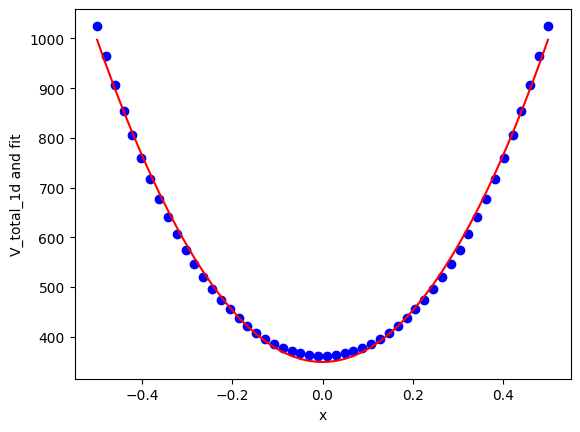

In [6]:

# === NEW CELL: harmonic fit of V_total_1d vs x_1d ===
import numpy as np

# enforce symmetry around x = 0: fit V(x) ≈ a x^2 + c
a, c = np.polyfit(x_1d, V_total_1d, 2)[0], np.polyfit(x_1d, V_total_1d, 2)[2]
k = 2*a   # spring constant in 1/2 k x^2 form

print(f"a = {a}")
print(f"c = {c}")
print(f"k = {k}")

print(f"\nHarmonic fit (quadratic form):  V(x) ≈ {a} * x**2 + {c}")
print(f"Harmonic fit (oscillator form): V(x) ≈ 0.5 * {k} * x**2 + {c}")

# === ADDED SCRIPT FOR PLOTTING ===
V_fit = a * x_1d**2 + c

plt.figure()
plt.scatter(x_1d, V_total_1d, color='blue')  # blue dot data
plt.plot(x_1d, V_fit, color='red')           # red fitted curve
plt.xlabel('x')
plt.ylabel('V_total_1d and fit')
#plt.title('Harmonic Fit of V_total_1d vs x_1d')
plt.show()

In [7]:
# === NEW CELL: Expectation ⟨z⟩ (Å) for He-3 and He-4 ===
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh

def _z_expectation(aax, aay, bbx, bby, mass, d_current=None):
    # grids
    x = np.linspace(aax, bbx, N + 1, dtype=float)
    y = np.linspace(aay, bby, N + 1, dtype=float)
    z = np.linspace(az, bz, Nz + 1, dtype=float)
    dx, dy, dz = x[1]-x[0], y[1]-y[0], z[1]-z[0]
    X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

    # laplacian
    diag_1 = np.ones(N + 1)
    diag_2 = np.array([diag_1, -2*diag_1, diag_1])
    B  = sparse.spdiags(diag_2, np.array([-1, 0, 1]), N + 1, N + 1)
    BB = (1/(dx**2)) * B
    CC = (1/(dy**2)) * B
    DD = (1/(dz**2)) * B
    C  = sparse.kronsum(BB, CC)
    D  = sparse.kronsum(C, DD)

    # kinetic
    T = (-(h_bar**2)/(2*mass)) * D

    # Cu+-He Morse
    distance = np.sqrt(X**2 + Y**2 + Z**2)
    z_Morse  = distance - ze_cuphe
    V_cuphe  = De_cuphe * (1.0 - np.exp(-alpha_cuphe * z_Morse))**2


    # four benzene rings (uses your current d unless overridden)
    d_used = d if d_current is None else float(d_current)
    rL = np.sqrt((X )**2 + Y**2          + Z**2)
    rR = np.sqrt((X)**2 + Y**2          + Z**2)
    rB = np.sqrt( X**2          + (Y )**2 + Z**2)
    rF = np.sqrt( X**2          + (Y )**2 + Z**2)
    V_sum = (
        De_benzhe * (1.0 - np.exp(-alpha_benzhe * (np.abs(rL - ze_benzhe)-d_used)))**2 +
        De_benzhe * (1.0 - np.exp(-alpha_benzhe * (np.abs(rR - ze_benzhe)+d_used)))**2 +
        De_benzhe * (1.0 - np.exp(-alpha_benzhe * (np.abs(rB - ze_benzhe)-d_used)))**2 +
        De_benzhe * (1.0 - np.exp(-alpha_benzhe * (np.abs(rF - ze_benzhe)+d_used)))**2
    )

    # total V and Hamiltonian
    V_total = sparse.diags((V_cuphe + V_sum).reshape(x.size * y.size * z.size), 0, format='csr')
    H = T + V_total

    # ground state
    vals, vecs = eigsh(H, k=1, which='SM', tol=1e-12, ncv=100)
    psi = vecs[:, 0].reshape((x.size, y.size, z.size))

    # expectation <z> with proper volume element (dV cancels in ratio)
    prob = np.abs(psi)**2
    z_exp = (prob * Z).sum() / prob.sum()
    return float(z_exp)

# use the same box as your cases[0]
_aax, _aay, _bbx, _bby = cases[0]['aax'], cases[0]['aay'], cases[0]['bbx'], cases[0]['bby']

for label, mass in [("3He", m_3He), ("4He", m_4He)]:
    zbar = _z_expectation(_aax, _aay, _bbx, _bby, mass)
    print(f"{label}  ⟨z⟩ = {zbar:.6f} Å")



3He  ⟨z⟩ = 1.864315 Å
4He  ⟨z⟩ = 1.840174 Å
